In [1]:
from doctest import testfile

import numpy as np
import matplotlib.pyplot as plt

## CODIFICADOR

In [5]:
#bits = [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
#SF = 7
#SF_Validos = [7, 8, 9, 10, 11, 12]

def coder(bits, SF):
    #Verificar si SF es valido
    if SF not in SF_Validos:
        raise ValueError("Invalido")
    #Verificar que la cantidad de bits sea multiplo del SF
    if len(bits) % SF != 0:
        raise ValueError("Numero de bits no es multiplo de SF")

       # Inicialización del vector de símbolos
    N_simbolos = len(bits) // SF
    s = np.zeros(N_simbolos, dtype=int)

    # Implementación de la ecuación (1)
    for i in range(N_simbolos):
        for h in range(SF):
            s[i] += bits[i * SF + h] * (2 ** h)

    return s

#print(coder(bits, SF))

[57 20]


###  Ejemplo de codificación usando la Ecuación (1)

#### Datos de entrada:

- `bits = [1, 0, 0, 1, 1, 1, 0]`
- `SF = 7`

#### Desarrollo paso a paso:

Agrupamos los 7 bits como un único símbolo, ya que `SF = 7`.

$\begin{aligned}
s &= w_0 \cdot 2^0 + w_1 \cdot 2^1 + w_2 \cdot 2^2 + w_3 \cdot 2^3 + w_4 \cdot 2^4 + w_5 \cdot 2^5 + w_6 \cdot 2^6 \\
  &= 1 \cdot 2^0 + 0 \cdot 2^1 + 0 \cdot 2^2 + 1 \cdot 2^3 + 1 \cdot 2^4 + 1 \cdot 2^5 + 0 \cdot 2^6 \\
  &= 1 \cdot 1 + 0 \cdot 2 + 0 \cdot 4 + 1 \cdot 8 + 1 \cdot 16 + 1 \cdot 32 + 0 \cdot 64 \\
  &= 1 + 0 + 0 + 8 + 16 + 32 + 0 \\
  &= 57
\end{aligned}$


####  Resultado esperado:

```python
[57]


## DECODIFICADOR

In [6]:
def decoder(s, SF):
    # Verificar que SF sea válido
    if SF not in SF_Validos:
        raise ValueError("SF inválido")

    bits_recuperados = []

    # Por cada símbolo, reconstruir los SF bits
    for simbolo in s:
        #bits_simbolos=[]
        for h in range(SF):
            # Obtener el bit de orden h (menos significativo primero)
            bit = (simbolo >> h) & 1
            bits_recuperados.append(bit)
        #bits_recuperados.append(bits_simbolos)

    return bits_recuperados
print(decoder([57,20], 7))

[1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]


### Decodificación manual del símbolo (Ecuación inversa de la codificación)

#### Dato recibido:

- Símbolo codificado: `s = 57`
- Spreading Factor: `SF = 7`

Queremos obtener los 7 bits originales que generaron este símbolo.


#### Desarrollo paso a paso:

| h (posición del bit) | Cálculo                          | Resultado `w_h` |
|----------------------|----------------------------------|-----------------|
| 0                    | \( (57 >> 0) \& 1 = 57 \& 1 \)   | 1               |
| 1                    | \( (57 >> 1) \& 1 = 28 \& 1 \)   | 0               |
| 2                    | \( (57 >> 2) \& 1 = 14 \& 1 \)   | 0               |
| 3                    | \( (57 >> 3) \& 1 = 7 \& 1 \)    | 1               |
| 4                    | \( (57 >> 4) \& 1 = 3 \& 1 \)    | 1               |
| 5                    | \( (57 >> 5) \& 1 = 1 \& 1 \)    | 1               |
| 6                    | \( (57 >> 6) \& 1 = 0 \& 1 \)    | 0               |



In [29]:
bit_randoms=np.random.randint(0,2,14)
Codificador = coder(bit_randoms, 7)
Decodificados = decoder(Codificador, 7)

def errores(lista1, lista2):

    error=0
    for i,j in zip(lista1, lista2):
        if (i != j):
            error+=1
    return error

def ber(bits_tx,bits_rx):
    BER=errores(bits_tx,bits_rx)/len(bit_randoms)
    return BER

print(ber(bit_randoms,Decodificados))

0.0


### Waveformer Former

In [18]:

def waveform_former(s, SF):
    M = 2 ** SF  # cantidad de muestras por chirp
    chirps = []

    for simbolo in s:
        k = np.arange(M)
        fase = ((simbolo + k) % M) * k / M
        chirp = (1 / np.sqrt(M)) * np.exp(1j * 2 * np.pi * fase)
        chirps.append(chirp)

    return np.array(chirps)  # matriz [N x M]




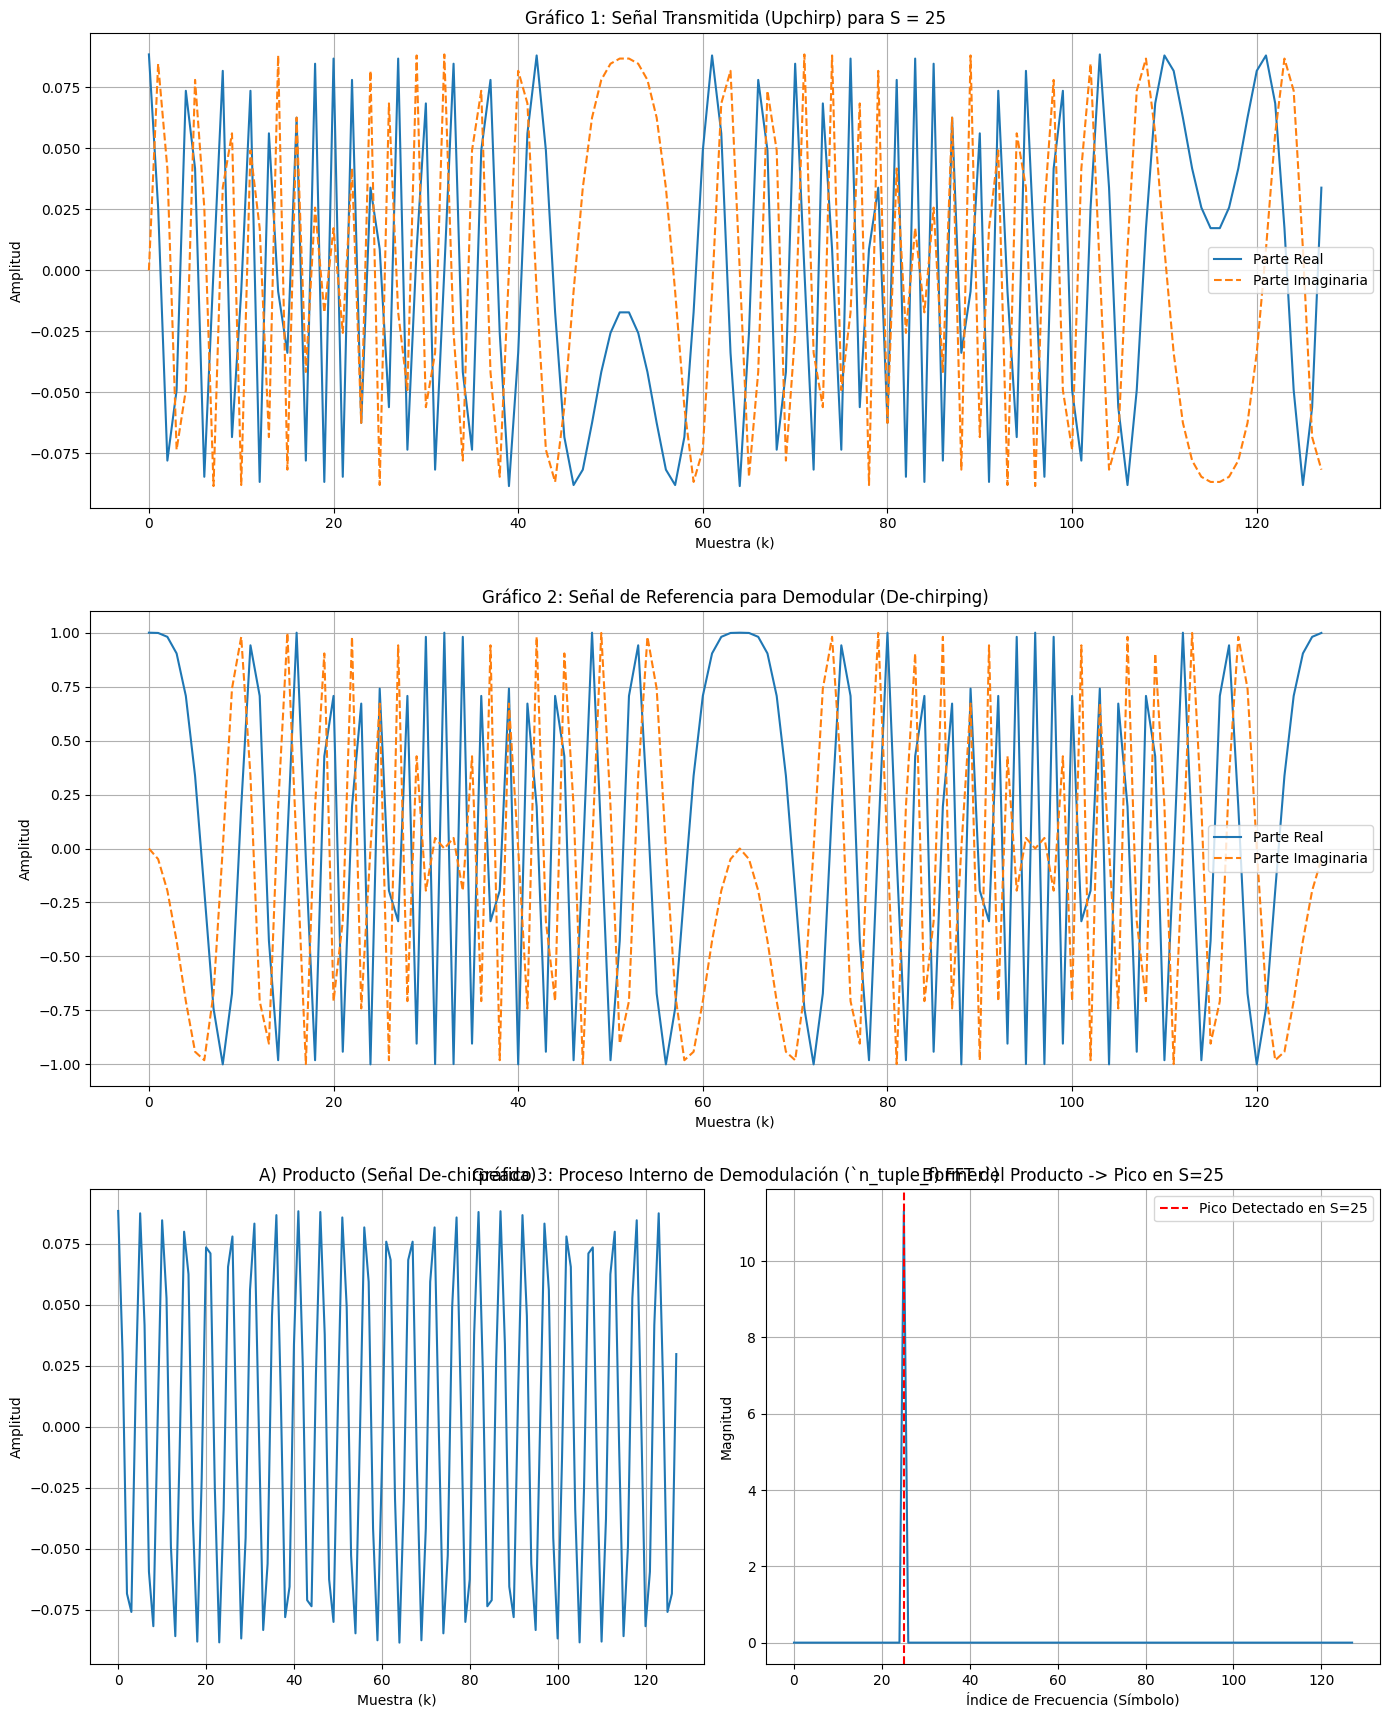

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Incluimos la función del codificador que ya creamos
def codificador_lora(S, SF):
    N = 2**SF
    if not (0 <= S < N):
        raise ValueError(f"El símbolo S={S} está fuera del rango válido.")
    n = np.arange(0, N)
    f_n = (S + n) % N
    phase = 2 * np.pi * f_n * n / N
    x_n = (1 / np.sqrt(N)) * np.exp(1j * phase)
    return x_n

# --- 1. Parámetros de la Simulación ---
SF = 7
S_original = 25  # El símbolo que vamos a codificar y luego encontrar
M = 2**SF
k = np.arange(M) # Vector de tiempo/frecuencia

# --- 2. Generar las señales ---

# Señal transmitida (Upchirp desde el "waveform generator")
chirp_transmitido = codificador_lora(S_original, SF)

# Señal de referencia para demodular (el "downchirp" del n_tuple_former)
# Nota: Esta es la señal de de-chirping (complejo conjugado del upchirp base)
dechirp_signal = np.exp(-1j * 2 * np.pi * k**2 / M)

# Proceso de demodulación
producto = chirp_transmitido * dechirp_signal
fft_producto = np.fft.fft(producto)
magnitud_fft = np.abs(fft_producto)
simbolo_detectado = np.argmax(magnitud_fft)


# --- 3. Crear los Gráficos ---

# ----- GRÁFICO 1: EL CHIRP TRANSMITIDO -----
plt.figure(figsize=(14, 18))

plt.subplot(3, 1, 1)
plt.plot(k, np.real(chirp_transmitido), label='Parte Real')
plt.plot(k, np.imag(chirp_transmitido), label='Parte Imaginaria', linestyle='--')
plt.title(f'Gráfico 1: Señal Transmitida (Upchirp) para S = {S_original}')
plt.xlabel('Muestra (k)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()


# ----- GRÁFICO 2: EL "DOWNCHIRP" DE REFERENCIA -----
# (Realmente la señal de de-chirping)
plt.subplot(3, 1, 2)
plt.plot(k, np.real(dechirp_signal), label='Parte Real')
plt.plot(k, np.imag(dechirp_signal), label='Parte Imaginaria', linestyle='--')
plt.title('Gráfico 2: Señal de Referencia para Demodular (De-chirping)')
plt.xlabel('Muestra (k)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()


# ----- GRÁFICO 3: EL PROCESO DE DEMODULACIÓN (`n_tuple_former`) -----
# Este gráfico tiene dos partes: el producto y la FFT

# Crear una figura interna para las dos subtramas
fig3 = plt.subplot(3, 1, 3)
plt.title(f'Gráfico 3: Proceso Interno de Demodulación (`n_tuple_former`)')
# Eliminar los ejes de la subtrama principal
plt.xticks([])
plt.yticks([])
plt.axis('off')

# Subtrama para el producto
ax1 = fig3.figure.add_subplot(3, 2, 5) # Posición 5 de una grilla de 3x2
ax1.plot(k, np.real(producto))
ax1.set_title('A) Producto (Señal De-chirpeada)')
ax1.set_xlabel('Muestra (k)')
ax1.set_ylabel('Amplitud')
ax1.grid(True)

# Subtrama para la FFT
ax2 = fig3.figure.add_subplot(3, 2, 6) # Posición 6 de una grilla de 3x2
ax2.plot(k, magnitud_fft)
ax2.axvline(x=simbolo_detectado, color='r', linestyle='--', label=f'Pico Detectado en S={simbolo_detectado}')
ax2.set_title(f'B) FFT del Producto -> Pico en S={simbolo_detectado}')
ax2.set_xlabel('Índice de Frecuencia (Símbolo)')
ax2.set_ylabel('Magnitud')
ax2.grid(True)
ax2.legend()


plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajustar para que los títulos no se superpongan
plt.show()

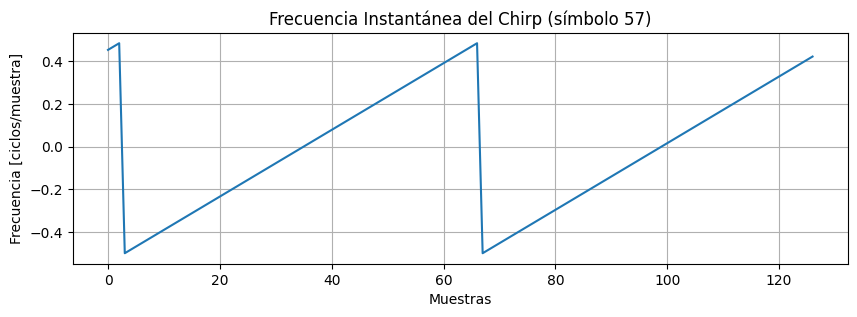

In [19]:

 # Generar un chirp para símbolo 57
SF = 7
chirp = waveform_former([57], SF)[0]

# Calcular fase y frecuencia instantánea
fase = np.unwrap(np.angle(chirp))
frecuencia_inst = np.diff(fase) / (2 * np.pi)

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(frecuencia_inst)
plt.title("Frecuencia Instantánea del Chirp (símbolo 57)")
plt.xlabel("Muestras")
plt.ylabel("Frecuencia [ciclos/muestra]")
plt.grid(True)
plt.show()

##  Waveform Former

###  Ecuación (2) del paper de Vangelista

La señal modulada transmitida para un símbolo $\begin{aligned}( s(nT_s) \in \{0, 1, \dots, 2^{SF} - 1\}) \end{aligned}$, según la Ecuación (2) del paper, se define como:



$\begin{aligned}
c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi \cdot \left[ \frac{(s(nT_s) + k) \bmod 2^{SF} \cdot k}{2^{SF}} \right]}
\quad \text{para } k = 0, 1, \dots, 2^{SF}-1
\end{aligned}$

Donde:
- $\begin{aligned} SF \end{aligned}$: Spreading Factor.
- $\begin{aligned} s(nT_s)\end{aligned}$: símbolo entero codificado (de 0 a \(2^{SF}-1\)).
- $\begin{aligned} k \end{aligned}$: índice de muestra temporal (discreto).
- $\begin{aligned} c(nT_s + kT) \end{aligned}$: muestra compleja de la forma de onda LoRa transmitida.

Esta señal es un "chirp" modulado en frecuencia, cuya frecuencia instantánea varía linealmente.




### n-Tuple Former

In [30]:
def n_tuple_former(received_chirps, SF):
    M = 2 ** SF
    k = np.arange(M)
    downchirp =  np.exp(-1j * 2 * np.pi * k**2 / M)

    simbolos_estimados = []
    for chirp in received_chirps:
        producto = chirp * downchirp
        fft_producto = np.fft.fft(producto) #Es la Transformada Rápida de Fourier (FFT) en NumPy
        simbolo_estimado = np.argmax(np.abs(fft_producto))
        simbolos_estimados.append(simbolo_estimado)

    return np.array(simbolos_estimados)


##  n-Tuple Former — Receptor Óptimo

###  Descripción Teórica (Sección III del paper de Vangelista)

La detección del símbolo transmitido se realiza aplicando un correlador discreto implementado como un receptor óptimo (n-Tuple Former). El procedimiento consiste en:

1. Multiplicar el chirp recibido por una señal conjugada de referencia conocida como "downchirp":
   $\begin{aligned}
   d(k) = e^{-j2\pi \cdot \frac{k^2}{2^{SF}}}
   \end{aligned}$
2. Aplicar una Transformada Rápida de Fourier (FFT) al producto.
3. Detectar el símbolo como el índice del valor máximo del espectro resultante.


###  Análisis Matemático

Para cada chirp recibido $\begin{aligned} r(k) \end{aligned}$, se realiza:

$\begin{aligned}
d(k) &= r(k) \cdot e^{-j2\pi \cdot \frac{k^2}{2^{SF}}} \\
R(f) &= \text{FFT}\left\{ d(k) \right\} \\
\hat{s} &= \arg \max_{f} \left| R(f) \right|
\end{aligned}$

Donde:
- $\begin{aligned} r(k) \end{aligned}$: chirp recibido de longitud $\begin{aligned} M = 2^{SF} \end{aligned}$
- $\begin{aligned} d(k) \end{aligned}$: señal desmodulada en base al downchirp
- $\begin{aligned} R(f) \end{aligned}$: transformada espectral
- $\begin{aligned} \hat{s} \end{aligned}$: símbolo estimado

Este proceso actúa como un **correlador en frecuencia**, donde cada símbolo posible produce un pico en una posición distinta del espectro. El símbolo transmitido es el que **mejor correlaciona** con el chirp recibido.



In [23]:
# Definimos funciones de utilidad
def errores_simbolos(s_tx, s_rx):
    #Cuenta cuántos símbolos difieren entre dos listas
    error = 0
    for i, j in zip(s_tx, s_rx):
        if i != j:
            error += 1
    return error

def ser(s_tx, s_rx):
    #
    return errores_simbolos(s_tx, s_rx) / len(s_tx)


In [24]:
SF = 7
bit_randoms = np.random.randint(0, 2, SF * 2)  # 2 símbolos

# Transmisor
s_tx = coder(bit_randoms, SF)
chirps_tx = waveform_former(s_tx, SF)

# Receptor (sin canal)
s_rx = n_tuple_former(chirps_tx, SF)

# Calcular SER
print("Símbolos transmitidos:", s_tx[:10])
print("Símbolos decodificados:", s_rx[:10])
print("SER:", ser(s_tx, s_rx))

Símbolos transmitidos: [89 35]
Símbolos decodificados: [89 35]
SER: 0.0


### Implementación del ruido AWGN

In [32]:
def energia_promedio_chirp(chirps):
    return np.mean(np.sum(np.abs(chirps)**2, axis=1))

In [26]:
def agregar_ruido_AWGN(chirps, SNR_dB):
    #M = chirps.shape[1]  # cantidad de muestras por chirp
    SNR_linear = 10**(SNR_dB / 10)

    Es = energia_promedio_chirp(chirps)
    sigma2 = Es / (2 * SNR_linear)

    ruido = np.sqrt(sigma2) * (np.random.randn(*chirps.shape) + 1j * np.random.randn(*chirps.shape))
    return chirps + ruido

## 🧪 Canal con Ruido AWGN y Curva BER/SER

### AWGN (Additive White Gaussian Noise)
Según la Sección IV del paper, el sistema puede ser evaluado bajo un modelo de canal con ruido aditivo blanco gaussiano complejo (AWGN)**.
Es un modelo de canal donde el ruido se suma a la señal transmitida:
- Media: 0
- Varianza: σ² = Eₛ / (2·SNRₗᵢₙₑₐᵣ)

Donde:

$\begin{aligned}
\text{SNR}_{\text{linear}} = 10^{\frac{\text{SNR}_{dB}}{10}}, \quad
\sigma^2 = \frac{E_s}{2 \cdot \text{SNR}_{\text{linear}}}
\end{aligned}$



### Procedimiento:
1. Se genera una señal chirp (modulada) por símbolo.
2. Se suma ruido Gaussiano complejo a la señal transmitida.
3. Se decodifica usando n-Tuple Former + FFT.
4. Se comparan los símbolos y bits originales con los decodificados.
5. Se calcula y grafica:
   - **BER**: tasa de error de bit.
   - **SER**: tasa de error de símbolo.

SNR = -12 dB → BER = 0.50026, SER = 0.99090
SNR = -10 dB → BER = 0.50020, SER = 0.98920
SNR =  -8 dB → BER = 0.50041, SER = 0.98810
SNR =  -6 dB → BER = 0.49337, SER = 0.97970
SNR =  -4 dB → BER = 0.49124, SER = 0.97460
SNR =  -2 dB → BER = 0.48686, SER = 0.96390
SNR =   0 dB → BER = 0.47209, SER = 0.93440


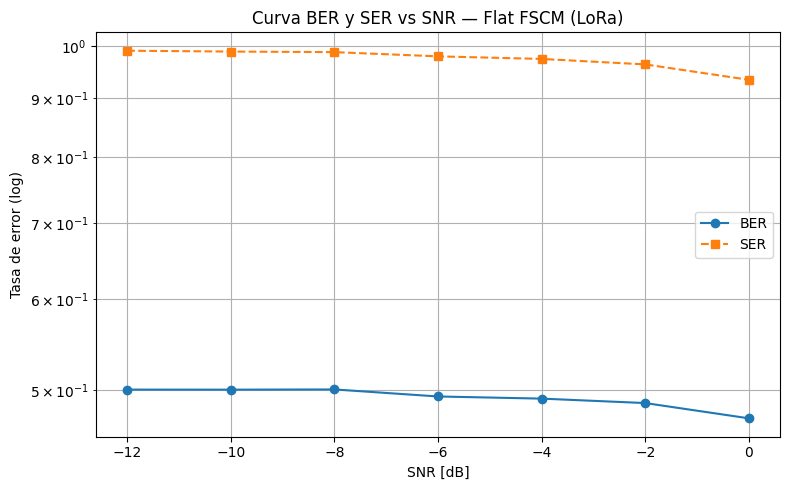

In [31]:
# SIMULACIÓN
SF = 7
N_SIMBOLOS = 10000
SNR_dBs = np.arange(-12, 1, 2)
BERs, SERs = [], []

bit_randoms = np.random.randint(0, 2, SF * N_SIMBOLOS)
s_tx = coder(bit_randoms, SF)
chirps_tx = waveform_former(s_tx, SF)

for SNR in SNR_dBs:
    chirps_noisy = agregar_ruido_AWGN(chirps_tx, SNR)
    s_rx = n_tuple_former(chirps_noisy, SF)
    bits_rx = decoder(s_rx, SF)
    BERs.append(ber(bit_randoms, bits_rx))
    SERs.append(ser(s_tx, s_rx))
    print(f"SNR = {SNR:>3} dB → BER = {BERs[-1]:.5f}, SER = {SERs[-1]:.5f}")

# GRÁFICO
plt.figure(figsize=(8, 5))
plt.semilogy(SNR_dBs, BERs, 'o-', label='BER')
plt.semilogy(SNR_dBs, SERs, 's--', label='SER')
plt.grid(True, which='both')
plt.xlabel("SNR [dB]")
plt.ylabel("Tasa de error (log)")
plt.title("Curva BER y SER vs SNR — Flat FSCM (LoRa)")
plt.legend()
plt.tight_layout()
plt.show()